# Fallback - Insert Retention Scores (RedShift)
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [1]:
import awswrangler as wr
import boto3
import getpass
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

XGDF-RLZB
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


In [ ]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 45
dbname = 'stlrRays'

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {dbname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

print(f"TOTAL ROWS: {df.shape[0]}")
df.head()



TOTAL ROWS: 11329


,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,tenure,distToVenue,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,fill_out_form,open_email,send_email,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,posting_records,resale_records,resale_atp,forward_records,cancel_records,email,inbound_email,inbound_phonecall,inperson_contact,internal_note,left_message,outbound_email,outbound_phonecall,phonecall,text,unknown,gender,childrenPresentInHH,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer
0,45,4037,10528412,2017,Partial Season,850.0,2017-10-01,1.000000,129,TRUE,3285,306,24.32,21,0,1,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1
1,45,4972,432468,2017,Partial Season,2188.0,2017-09-19,0.295455,124,TRUE,5840,304,25.77,7,1,1,0,2,1,0,5,163,0,0.030675,0.006135,0.200000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1
2,45,19483,1860700,2017,Full Season,60440.0,2017-10-01,0.762500,124,TRUE,5840,306,1604.67,66,1,12,3,2,0,0,0,0,0,0.000000,0.000000,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1
3,45,22851,100143414,2017,Partial Season,406.0,2017-09-30,0.818182,124,TRUE,2190,305,27.56,15,0,4,0,0,2,0,3,128,2,0.023438,0.015625,0.666667,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1
4,45,36976,5869210,2017,Partial Season,1035.0,2017-09-20,0.761905,124,TRUE,4380,305,66.03,17,1,2,2,0,4,0,132,198,0,0.666667,0.020202,0.030303,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1


### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (7115, 11)
Unseen Data For Predictions: (1256, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [ ]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

### Let's load in our 2021 season data and get retention scores using the model:

In [8]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(2958, 11)

In [10]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

df_predictions.head()

,dimCustomerMasterId,attendancePercent,distToVenue,isNextYear_Buyer,lkupClientId,productGrouping,recency,recentDate,source_tenure,totalSpent,year,Label,Score_0,Score_1
8371,8524,0.0,44.18,0,45,Membership Bronze,0,1970-01-01,1460,500.0,2022,0,0.3983,0.6017
8372,8665,0.0,72.53,0,45,Membership Bronze,0,1970-01-01,2190,2000.0,2022,0,0.5006,0.4994
8374,12957,0.0,137.63,0,45,Membership Bronze,0,1970-01-01,2190,2000.0,2022,0,0.5198,0.4802
8375,17462,0.0,40.78,0,45,Membership Bronze,0,1970-01-01,1825,2000.0,2022,0,0.6164,0.3836
8376,19483,0.0,1604.67,0,45,Full Season,0,1970-01-01,5840,70120.0,2022,0,0.4703,0.5297


### We can create some histograms to visualize each model distribution:

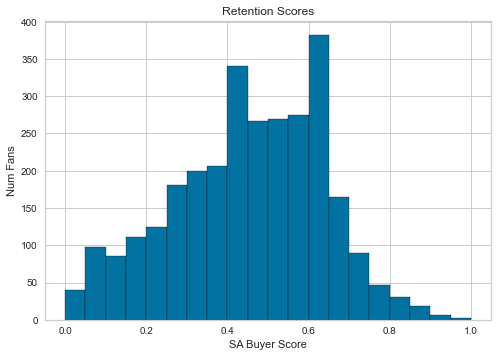

In [11]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [12]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]         3
(0.9, 0.95]         6
(0.85, 0.9]        18
(0.8, 0.85]        31
(0.75, 0.8]        47
(0.7, 0.75]        90
(0.65, 0.7]       165
(0.6, 0.65]       382
(0.55, 0.6]       275
(0.5, 0.55]       269
(0.45, 0.5]       266
(0.4, 0.45]       341
(0.35, 0.4]       206
(0.3, 0.35]       200
(0.25, 0.3]       180
(0.2, 0.25]       125
(0.15, 0.2]       111
(0.1, 0.15]        86
(0.05, 0.1]        97
(-0.001, 0.05]     40
Name: Score_1, dtype: int64

### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [16]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = "qa-app",
    database = dbname.lower(),
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY!")

CREDENTIALS RETRIEVED SUCCESSFULLY!


### Before we insert new scores, let's grab a list of the most recent scores (currVersnFlag=1) so we can update them after the new scores are pushed:

In [17]:
sql_statement = f"""
    SELECT *
    FROM {dbname.lower()}.dw.customerretentionscores 
    WHERE currversnflag = 1
    AND lkupclientid = {lkupclientid}
"""

df_recent_scores = wr.data_api.redshift.read_sql_query(
    sql = sql_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_recent_scores.shape[0]}")

TOTAL RECORDS: 2144


### Insert the new scores into the customerretentionscores table in batches:

In [18]:
batch_size = 100
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {dbname} ({lkupclientid})")

fields = f"""
INSERT INTO {dbname}.dw.customerretentionscores (
    attendancePercentage,
    currversnflag,
    dimcustomermasterid,
    insertdate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonYear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(1)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    wr.data_api.redshift.read_sql_query(
        sql = insert_statement, 
        con = conn
    )
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 2938 NEW RETENTION SCORES TO DATABASE: stlrRays (45)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2200
 > INSERTED BATCH 23 : ROWS 2201 - 2300
 > INSERTED BATCH 24 : ROWS 2301 - 2400
 > INSE

### Now let's update the old scores to currVersFlag = 0

In [19]:
print(f"UPDATING {len(df_recent_scores)} OLD RETENTION SCORES IN DATABASE:")

ids = ', '.join(map(str, list(df_recent_scores['customerretentionscoreid'])))
if len(ids) > 0:
    
    update_statement = f"""
        UPDATE {dbname}.dw.customerretentionscores
        SET currversnflag = 0 
        WHERE customerretentionscoreid IN ({ids})
        AND lkupclientid = {lkupclientid}
    """

    wr.data_api.redshift.read_sql_query(
        sql = update_statement, 
        con = conn
    )

    print(f"UPDATED {len(df_recent_scores)} SUCCESSFULLY")
    
else:
    print(f"NO OLD SCORES TO UPDATE")

UPDATING 2144 OLD RETENTION SCORES IN DATABASE:
UPDATED 2144 SUCCESSFULLY


### Let's query RedShift to make sure our records got into the database:

In [20]:
select_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

df_current_scores = df_scores[df_scores['currversnflag'] == 'true']

print(f"TOTAL RECORDS: {df_current_scores.shape[0]}")
df_scores['currversnflag'].value_counts()

TOTAL RECORDS: 2938


false    279059
true       2938
Name: currversnflag, dtype: int64